<h1>Dog Breed Classification</h1>
<a id='Intro'></a>
<h1>Continued</h1>

This is a part two interactive notebook showcasing further modeling on the dog breed classification data. 
<br>
The part one notebook can be found: https://github.com/matthewjchin/dogbreedclassification/blob/main/dog_breed_class.ipynb

In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load
# # It would be recommended to run this notebook on Colab or Kaggle

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         os.path.join(dirname, filename)

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Import basic libraries
import pandas as pd
import numpy as np
import os

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(94)

In [3]:
os.getcwd()

'/Users/mjchin/Desktop/CUB_OMS_CS/Summer_2025/CSCA_5642_Intro_DL/FinalProject/dogbreedclassification'

In [4]:
# os.chdir("/kaggle/input/dog-breed-identification")
# os.getcwd()

In [5]:
# The path to the files should not be like this all the time; everything done offline
# Actual project is found on Kaggle, but elected to run on own environment which best fit needs
labels = pd.read_csv("labels.csv")
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [6]:
# train_dir = '/kaggle/input/dog-breed-identification/train'
# Locally, not on Kaggle

train_dir = 'dog-breed-identification/train'

In [7]:
# Add entire folder path to image files and make it a column
labels['path'] = labels['id'].apply(lambda x : train_dir + "/"+ x + '.jpg')
labels.head()

,id,breed,path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,dog-breed-identification/train/000bec180eb18c7...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,dog-breed-identification/train/001513dfcb2ffaf...
2,001cdf01b096e06d78e9e5112d419397,pekinese,dog-breed-identification/train/001cdf01b096e06...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,dog-breed-identification/train/00214f311d5d224...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,dog-breed-identification/train/0021f9ceb3235ef...


In [8]:
# Import TensorFlow, Keras, Scikit-learn libraries to be used

import tensorflow as tf # Use tf v2.12.0
import keras
from keras import layers, models, callbacks, optimizers
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

tf.random.set_seed(104)

In [9]:
# Get the TensorFlow Version - we are using v2.12.0
print(tf.__version__, keras.__version__)

2.17.0 3.4.1


In [10]:
# Set up constants for model
RANDOM_STATE = 50
IMG_SIZE = 256
DOG_BREEDS = len(labels['breed'].unique())
LEARNING_RATE = 0.005
BATCH_SIZE = 32

# Epochs value may vary based on number of tests
EPOCHS = 5

In [11]:
# Check if GPU is available - only on Colab or Kaggle

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPU being used for training")
    for gpu in gpus:
        print(f"GPU Name: {gpu.name}")
else: # Use CPU
    BATCH_SIZE=16
    EPOCHS = 5
    print("Using CPU")


Using CPU


In [12]:
# Create a label encoding
encoder = LabelEncoder()
labels['breed_id']= encoder.fit_transform(labels['breed'])
labels.head()


,id,breed,path,breed_id
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,dog-breed-identification/train/000bec180eb18c7...,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,dog-breed-identification/train/001513dfcb2ffaf...,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,dog-breed-identification/train/001cdf01b096e06...,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,dog-breed-identification/train/00214f311d5d224...,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,dog-breed-identification/train/0021f9ceb3235ef...,49


In [13]:
'''Set up variables x, y to load images from train_dir into array/matrix form (seen in last cell)
Adjust size as appropriate and put everything in list form
Create dataset y of dummy variables of dog breeds and then get shapes

x - type numpy array
y - type dataframe
'''


x= np.array([img_to_array(load_img(image, target_size=(IMG_SIZE, IMG_SIZE)))
             for image in labels['path'].values.tolist()])
y = pd.get_dummies(labels['breed'])
print(x.shape, y.shape)

(10222, 256, 256, 3) (10222, 120)


In [14]:
# Do the train-test split
# Implement the training and validation sets for x, y so that train-test size is 80%-20%
 
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2)

print(x_train.shape,y_train.shape)
print(x_valid.shape,y_valid.shape)

(8177, 256, 256, 3) (8177, 120)
(2045, 256, 256, 3) (2045, 120)


In [15]:
print(type(x_train), type(x_valid), type(y_train), type(y_valid))
print(x_train.dtype, x_valid.dtype)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
float32 float32


<a id='Different'></a>
## <h1>Trying a Different Model</h1>

Try another model to see if we can get better predictions.<br>
Originally, we used a basic Sequential model to calculate probabilities on what dog breed it thinks an image is.<br>
Use VGG16 deep CNN for image classification, where there are 16 layers of artificial neurons.<br>

First, perform some image augmentation using ImageDataGenerator on the train data.<br>
Also, set up a data generator for validation data.<br>

We will use VGG16 as the architecture to try and get better predictions.

In [16]:
# Set up the ImageDataGenerators for the training and validation data

train_data_gen = ImageDataGenerator(
    rescale=1./255., rotation_range=40,
    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
    zoom_range=0.2, horizontal_flip=True
)

valid__data_gen = ImageDataGenerator(rescale=1./ 255.)

In [17]:
'''
This simply will not work for numpy arrays. The training and validation sets x_train, x_valid
are numpy arrays type float which are four dimensions.

As much as I want to do more preprocessing and flow the training and validation images, it simply is
not possible to do so with this type of data since I am seeking to create probability predictions
with my model's implementation.
'''

# # Flow training images in batches of 20 using train_datagen generator
# train_generator = train_data_gen.flow_from_dataframe(
#     x_train,
#     batch_size=20,
#     class_mode='categorical',
#     target_size=(224, 224)
# )

# # Flow validation images in batches of 20 using test_datagen generator
# validation_generator = test_data_gen.flow_from_dataframe(
#     x_valid,
#     batch_size=20,
#     class_mode='categorical',
#     target_size=(224, 224)
# )

"\nThis simply will not work for numpy arrays. The training and validation sets x_train, x_valid\nare numpy arrays type float which are four dimensions.\n\nAs much as I want to do more preprocessing and flow the training and validation images, it simply is\nnot possible to do so with this type of data since I am seeking to create probability predictions\nwith my model's implementation.\n"

No flowing was done because it caused my notebook kernel to crash. Only ImageDataGenerators were created 
Thus, this was a major drawback as to why some of the percentages are down is because none of the training images flowed properly because of how complex x_train and x_valid are as numpy arrays each in four dimensions.

In [18]:
from keras import layers
from keras import models

from keras.applications import (ResNet50, ResNet101, 
                                InceptionResNetV2, InceptionV3,
                                EfficientNetB0, 
                                VGG16, VGG19)

img_shape = (IMG_SIZE, IMG_SIZE, 3)
base_model = VGG16(input_shape=img_shape, include_top=False, weights='imagenet')

for layer in base_model.layers: # Not needed to train all 16 layers
    layer.trainable = False


In [19]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [20]:
last_layer = base_model.get_layer('block5_pool')

In [21]:
last_layer_output = last_layer.output
last_layer_output.name

'keras_tensor_18'

In [22]:
last_layer_output.shape

(None, 8, 8, 512)

In [23]:
from keras import optimizers
from keras import layers
# Set up layers for the model, then initialize using base to compile the model

# Get layers to be one single dimension
x = layers.Flatten()(last_layer_output)

# Add a layer with 256 units and ReLU, which would make this layer fully connected
x = layers.Dense(256, activation='relu')(x)

# Normalize the batch
x = layers.BatchNormalization()(x)

# Add another layer with 256 units and ReLU, which would make this layer fully connected
x = layers.Dense(256, activation='relu')(x)

# Make a sigmoid layer with sigmoid
x = layers.Dense(1, activation='sigmoid')(x)

# Set dropout rate to 0.6
x = layers.Dropout(0.6)(x)

# Normalize the batch again
x = layers.BatchNormalization()(x)

# Initialize the output variable using dense softmax layer
output = layers.Dense(120, activation='softmax')(x)

model = models.Model(base_model.input, output)
# model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0005), 
#               loss='binary_crossentropy', metrics=['acc'])

model.compile(
	optimizer='adam',
	loss='categorical_crossentropy',
	metrics=['accuracy']
)



In [24]:
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid),
                    epochs=10, verbose=1,
                   )


Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 698s 3s/step - accuracy: 0.0122 - loss: 4.7883 - val_accuracy: 0.0176 - val_loss: 4.7723
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 686s 3s/step - accuracy: 0.0141 - loss: 4.7681 - val_accuracy: 0.0186 - val_loss: 4.7592
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 672s 3s/step - accuracy: 0.0144 - loss: 4.7494 - val_accuracy: 0.0215 - val_loss: 4.7334
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 645s 3s/step - accuracy: 0.0174 - loss: 4.7280 - val_accuracy: 0.0205 - val_loss: 4.7020
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 642s 3s/step - accuracy: 0.0152 - loss: 4.7059 - val_accuracy: 0.0225 - val_loss: 4.6695
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 647s 3s/step - accuracy: 0.0146 - loss: 4.6950 - val_accuracy: 0.0181 - val_loss: 4.6542
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 637s 2s/step - accuracy: 0.0160 - loss: 4.6805 - val_accuracy: 0.0181 - val_loss: 4.6197
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 655s 3s/step - accuracy: 0.0156 - loss: 4.6728 - val_accu

In [26]:
# Call valid__data_gen to flow images from directory of test
valid_gen= valid__data_gen.flow_from_directory('dog-breed-identification',  target_size=(IMG_SIZE, IMG_SIZE), classes=['test'])

Found 10357 images belonging to 1 classes.


In [27]:
# Run predictions on the model using the test generator
y_pred = model.predict(valid_gen)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


324/324 ━━━━━━━━━━━━━━━━━━━━ 661s 2s/step


In [28]:
y_pred

array([[0.00729709, 0.007005  , 0.00995483, ..., 0.01127176, 0.00678398,
        0.00574739],
       [0.00729745, 0.00700571, 0.00995418, ..., 0.01127107, 0.00678434,
        0.00574796],
       [0.0072973 , 0.0070054 , 0.00995446, ..., 0.01127137, 0.00678419,
        0.00574772],
       ...,
       [0.0072971 , 0.00700501, 0.00995481, ..., 0.01127175, 0.00678399,
        0.0057474 ],
       [0.00729767, 0.00700614, 0.00995378, ..., 0.01127064, 0.00678456,
        0.00574831],
       [0.00729723, 0.00700527, 0.00995458, ..., 0.0112715 , 0.00678412,
        0.00574761]], dtype=float32)

In [29]:
y_pred.shape

(10357, 120)

In [31]:
import re

# Get all filenames and put them into the list for the submission file
file_list = valid_gen.filenames
id_list = []
for name in file_list:
    m = re.sub('test/', '', name)
    m = re.sub('.jpg', '', m)
    id_list.append(m)


In [32]:
# Should now be able to see all the probabilities that the initial model predicted in terms of dog breeds

submission = pd.read_csv('vgg16_sample_submission.csv')
submission.head()
submission['id'] = id_list
submission.iloc[:,1:] = y_pred
submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.007297,0.007005,0.009955,0.008706,0.009105,0.008407,0.006952,0.012239,0.00943,...,0.007237,0.00859,0.007617,0.007855,0.009338,0.009202,0.005706,0.011272,0.006784,0.005747
1,00102ee9d8eb90812350685311fe5890,0.007297,0.007006,0.009954,0.008706,0.009105,0.008406,0.006952,0.012238,0.00943,...,0.007238,0.00859,0.007617,0.007854,0.009337,0.009201,0.005707,0.011271,0.006784,0.005748
2,0012a730dfa437f5f3613fb75efcd4ce,0.007297,0.007005,0.009954,0.008706,0.009105,0.008406,0.006952,0.012239,0.00943,...,0.007237,0.00859,0.007617,0.007854,0.009338,0.009201,0.005707,0.011271,0.006784,0.005748
3,001510bc8570bbeee98c8d80c8a95ec1,0.007297,0.007005,0.009955,0.008706,0.009105,0.008407,0.006952,0.012239,0.00943,...,0.007237,0.00859,0.007617,0.007854,0.009338,0.009202,0.005706,0.011272,0.006784,0.005747
4,001a5f3114548acdefa3d4da05474c2e,0.007297,0.007006,0.009954,0.008706,0.009105,0.008406,0.006952,0.012238,0.00943,...,0.007238,0.00859,0.007617,0.007854,0.009338,0.009201,0.005707,0.011271,0.006784,0.005748


In [33]:
history.history

{'accuracy': [0.012229423969984055,
  0.01394154317677021,
  0.014308426529169083,
  0.014797602780163288,
  0.01467530895024538,
  0.015653662383556366,
  0.01638742722570896,
  0.01491989754140377,
  0.016632016748189926,
  0.0169989001005888],
 'loss': [4.784600257873535,
  4.7660627365112305,
  4.745950698852539,
  4.727171421051025,
  4.704167366027832,
  4.693231582641602,
  4.675484657287598,
  4.668525695800781,
  4.6618781089782715,
  4.65083646774292],
 'val_accuracy': [0.017603911459445953,
  0.018581906333565712,
  0.021515892818570137,
  0.02053789794445038,
  0.022493887692689896,
  0.018092909827828407,
  0.018092909827828407,
  0.018581906333565712,
  0.01955990307033062,
  0.018092909827828407],
 'val_loss': [4.772305488586426,
  4.759232521057129,
  4.733364105224609,
  4.701958179473877,
  4.669493198394775,
  4.6541852951049805,
  4.6197075843811035,
  4.6160807609558105,
  4.597080707550049,
  4.578061103820801]}

In [34]:
# Plot accuracy and loss
# Number of values in each list should align to how many epochs were needed to train
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print(len(loss), type(loss))

10 <class 'list'>


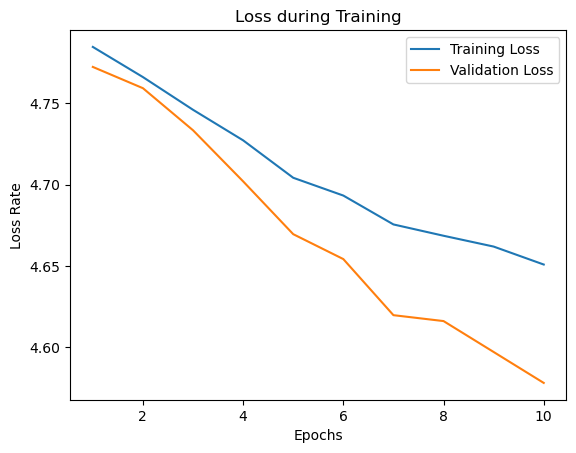

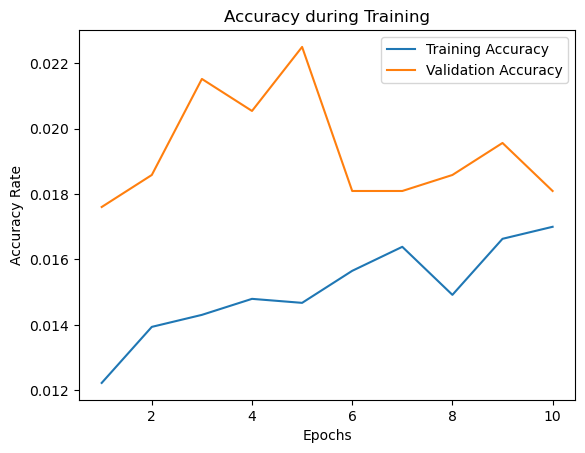

In [35]:
# Initialize x-axis for plots - first plot the loss, then the accuracy
epochs = list(range(1, len(loss) + 1))

# Loss
plt.figure()
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title("Loss during Training")
plt.xlabel("Epochs")
plt.ylabel("Loss Rate")
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title("Accuracy during Training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Rate")
plt.legend()
plt.show()